In [72]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [73]:
H = 400
W = 400
f = 1200

In [74]:
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))



u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)


In [75]:
def plot_rays(o, d, t):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    
    for p1, p2 in zip(pt1[::100], pt2[::100]):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    
    plt.show()

In [76]:
class Sphere():
    
    def __init__(self, p, r, c):
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        
        # (x- xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2 
        
        cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 <= self.r**2
                
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[cond] = self.c
        density[cond] = 5
        
        return colors, density

In [77]:
def compute_accumulated_transmittance(betas):
    device = 'cpu'
    betas = betas.cpu().numpy()
    accumulated_transmittance = np.cumprod(betas,1)
    accumulated_transmittance = (torch.from_numpy(accumulated_transmittance)).to(device)
    accumulated_transmittance[:, 0] = 1.
    return accumulated_transmittance

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=500, device='cpu'):
    
    rays_o = rays_o.to(torch.float32).to(device)
    rays_d = rays_d.to(torch.float32).to(device)
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10]).to(device))) 
    
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]
    
    colors, density = model.intersect(x.reshape(-1, 3))
    colors = colors.to(torch.float32).to(device)
    
    
    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins)).to(torch.float32).to(device)
    print(colors.shape,density.shape)
    
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # [nb_rays, nb_bins, 1]
    print(T.get_device(),alpha.get_device(),colors.get_device())
    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    
    return c

In [78]:
model = Sphere(torch.tensor([0, 0, -1]), 0.1, torch.tensor([1., 2., 0.]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

torch.Size([160000, 500, 3]) torch.Size([160000, 500])
-1 -1 -1


In [79]:
img = px_colors.reshape(H, W, 3).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


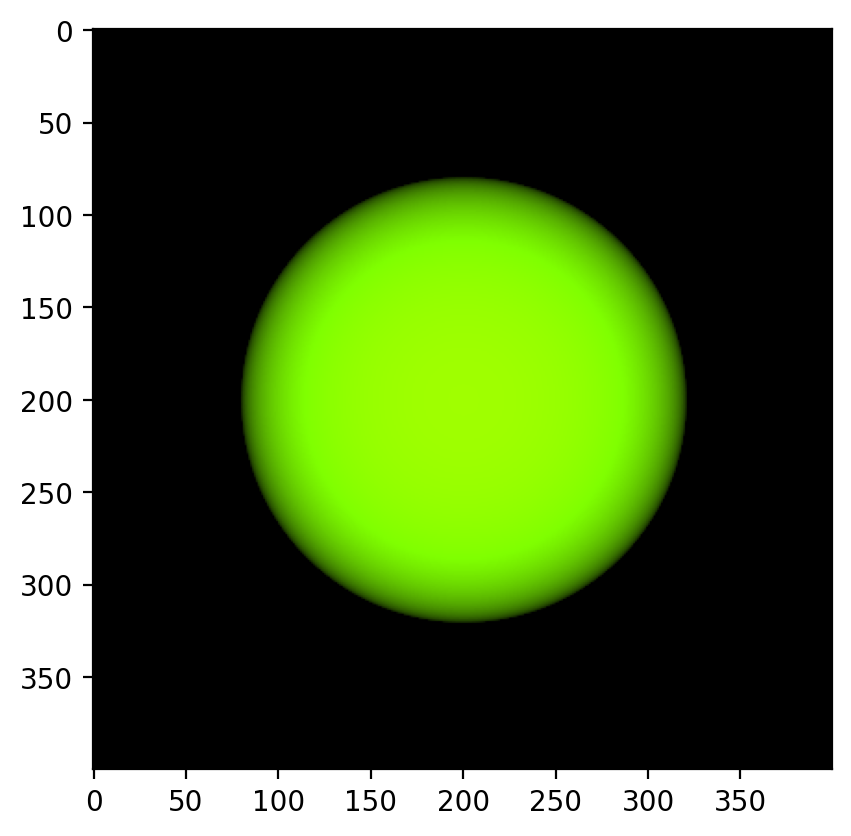

In [80]:

plt.figure(dpi=200)
plt.imshow(img)